<a href="https://colab.research.google.com/github/Kirtitari/UAV-Crowd-Counting/blob/master/TrainVal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
!git clone https://github.com/Neerajj9/CSRNet-keras.git

/content


In [10]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15266382591639084055
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14134871777705960113
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip "/content/drive/My Drive/VisdroneCrowdCounting/train_test_Visdrone2020_simple_density.zip"
!unzip "/content/drive/MyDrive/VisDrone2019-MOT-train.zip" -d "/content/train"
!unzip "/content/drive/MyDrive/VisDrone2019-MOT-test-dev.zip" -d "/content/test"


**pretrained model**

In [42]:
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import mean_squared_error
from keras.initializers import RandomNormal
#from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras.models import Model,Sequential
from keras.layers import *
from keras import backend as K
from keras.models import model_from_json
from matplotlib import cm as CM
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import numpy as np
import random
import math
import sys
import matplotlib.legend_handler

In [20]:
root = '/content/'

In [29]:
train = os.path.join(root,'train','sequences')
test = os.path.join(root,'test','sequences')
path_sets = [train, test]

In [34]:
path_sets[1]

'/content/test/sequences'

In [38]:
img_paths_test = []
for paths in os.listdir(path_sets[1]):
  paths = path_sets[1] + "/" + paths
  #print(paths)
  for img_path in glob.glob(os.path.join(paths, '*.jpg')):
        #print(img_path)
        img_paths_test.append(str(img_path))
print("Test image importation .. Total images : ",len(img_paths_test))
test_sum = len(img_paths_test)

/content/test/sequences/uav0000201_00000_v
/content/test/sequences/uav0000188_00000_v
/content/test/sequences/uav0000119_02301_v
/content/test/sequences/uav0000306_00230_v
/content/test/sequences/uav0000249_00001_v
/content/test/sequences/uav0000009_03358_v
/content/test/sequences/uav0000073_00600_v
/content/test/sequences/uav0000088_00290_v
/content/test/sequences/uav0000120_04775_v
/content/test/sequences/uav0000297_00000_v
/content/test/sequences/uav0000370_00001_v
/content/test/sequences/uav0000249_02688_v
/content/test/sequences/uav0000073_04464_v
/content/test/sequences/uav0000077_00720_v
/content/test/sequences/uav0000161_00000_v
/content/test/sequences/uav0000297_02761_v
/content/test/sequences/uav0000355_00001_v
Test image importation .. Total images :  6635


In [92]:
img_paths_train = []
for paths in os.listdir(path_sets[0]):
  paths = path_sets[0] + "/" + paths
  for img_path in glob.glob(os.path.join(paths, '*.jpg')):
        img_paths_train.append(str(img_path))
print("Train image importation .. Total images : ",len(img_paths_train))
train_sum = len(img_paths_train)

Train image importation .. Total images :  24201


NameError: ignored

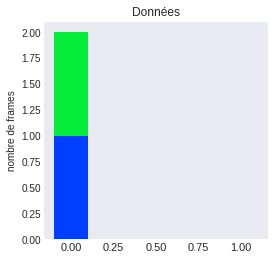

In [93]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
plt.style.use("seaborn-bright")
plt.figure(figsize=(4,4))
N = 2
SMALL_SIZE = 11
Nb1=Nb2=1
menMeans = (Nb1,0)
womenMeans = (Nb2,0)
ind = np.arange(N)    # the x locations for the groups
width = 0.2      # the width of the bars: can also be len(x) sequence
p1 = plt.bar(ind, menMeans, width)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans)
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.ylabel('nombre de frames')
plt.title("Données")
plt.xticks(ind-0.3, (es + 'Visdrone 2020 CC \n avec augmentation', ''))
plt.yticks(np.arange(0, Nb1+Nb1*0.4, 100))
#plt.legend(loc="upper left")
plt.legend(["donnée d'entrainement", "donnée de validation"], loc='upper right')

plt.show()

In [94]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    """width, height = im.size 
    newsize = (width // 2, height //2)
    im = im.resize(newsize)"""
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225

    #print(im.shape)
    #im = np.expand_dims(im,axis  = 0)
    return im

def get_input(path):
    #print(path)
    path = path[0] 
    img = create_img(path)
    return(img)

def get_output(path):
    #import target
    #resize target
    #print(path)
    gt_file = h5py.File(path,'r')
    target = np.asarray(gt_file['density'])
    img = cv2.resize(target,(int(target.shape[1]//8),int(target.shape[0]//8)),interpolation = cv2.INTER_CUBIC)*64
    img = np.expand_dims(img,axis  = 2)
    #print(img.shape)
    return img

def preprocess_input(image,target):
    #crop image
    #crop target
    #resize target
    crop_size = (int(image.shape[0]/2),int(image.shape[1]/2))
    #imm = np.resize(image,((image.shape[0]//2),int(image.shape[1]//2)))
    #tar = np.resize(target,((image.shape[0]//2),int(image.shape[1]//2)))
    if random.randint(0,9)<= -1:            
            dx = int(random.randint(0,1)*image.shape[0]*1./2)
            dy = int(random.randint(0,1)*image.shape[1]*1./2)
    else:
            dx = int(random.random()*image.shape[0]*1./2)
            dy = int(random.random()*image.shape[1]*1./2)

    #print(crop_size , dx , dy)
    img = image[dx : crop_size[0]+dx , dy:crop_size[1]+dy]
    
    target_aug = target[dx:crop_size[0]+dx,dy:crop_size[1]+dy]
    #print(img.shape)

    return(img,target_aug)

In [95]:
#Image data generator 
def image_generator(files, batch_size = 64):
    while True:        
        input_path = np.random.choice(a = files, size = batch_size)
        #print(input_path)
        batch_input = []
        batch_output = [] 
          
        #for input_path in batch_paths:
        
        inputt = get_input(input_path)
        output = get_output(input_path[0].replace('.jpg','.h5').replace('sequences','ground_truth') )
       
        batch_input += [inputt]
        batch_output += [output]

        batch_x = np.append(batch_x, batch_xx)
        batch_y = np.append(batch_y, batch_yy)
        yield( batch_x, batch_y )

In [96]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    model_json = model.to_json()
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [97]:
def init_weights_vgg(model):
    #vgg =  VGG16(weights='imagenet', include_top=False)
    
    json_file = open('/content/CSRNet-keras/models/VGG_16.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/CSRNet-keras/weights/VGG_16.h5")
    
    vgg = loaded_model
    
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
    offset=0
    i=0
    while(i<10): 
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            
        else:
            offset=offset+1

    return (model)

In [98]:
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [99]:
def mae(y_true, y_pred):
    return abs(K.sum(y_true) - K.sum(y_pred))
    #return mean_absolute_error(np.array(K.sum(y_true)),np.array(K.sum(y_pred)))
def mse(y_true, y_pred):
    #return tf.math.sqrt((K.sum(y_true) - K.sum(y_pred)) * (K.sum(y_true) - K.sum(y_pred)))
    #tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.math.sqrt(K.sum(y_true) * K.sum(y_pred))
    #return tf.math.sqrt(K.sum(y_true) - K.sum(y_pred))
    

In [141]:
K.clear_session()
def CrowdNet():  
            #Variable Input Size
            rows = None
            cols = None
            
            #Batch Normalisation option
            
            batch_norm = 0
            kernel = (3, 3)
            init = RandomNormal(stddev=0.01)
            model = Sequential() 
            #custom VGG:
            
            if(batch_norm):
                model.add(Conv2D(64, kernel_size = kernel,  input_shape = (rows,cols,3),activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))#64
                model.add(BatchNormalization())
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))#128
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                
            else:
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same',input_shape = (rows, cols, 3), kernel_initializer = init))
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
            #Conv2D
            model.add(Dropout(0.3))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = "same"))
            model.add(Dropout(0.3))
            model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Dropout(0.1))
            model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Dropout(0.1))
            model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
            sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
            #model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
            #tf.keras.losses.Huber()
            model.compile(optimizer=Adam(1e-5), loss='accuracy', metrics=[mae, "mse"])
            #optimizer=Adam(1e-5)
            model = init_weights_vgg(model)
            
            return model

In [142]:
!rm -r ./log

rm: cannot remove './log': No such file or directory


In [143]:
model = CrowdNet()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [144]:
#poursuivre trainig
#model = load_model()

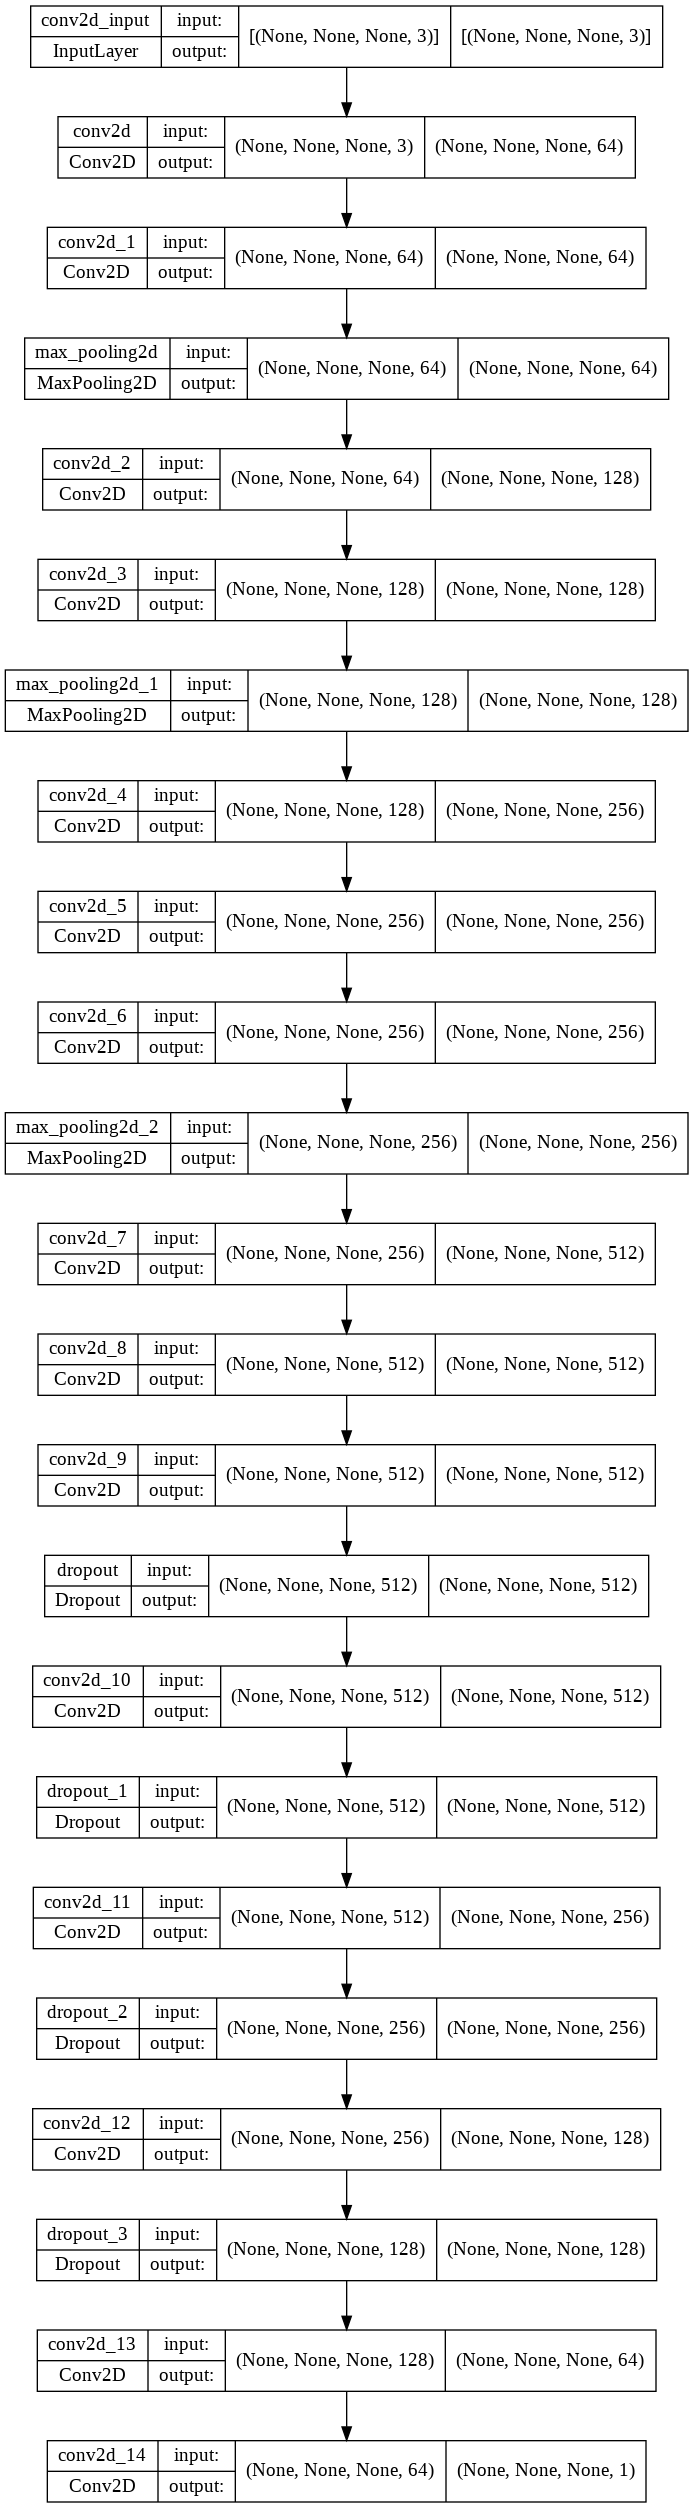

In [145]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [146]:
log_dir = './log/'

In [147]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    1792      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 64)   0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 128)   73856     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 128)   147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                    

In [148]:
print(model.get_weights())

[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
          -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
         [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
          -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
         [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
          -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],

        [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
          -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
         [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
          -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
         [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
          -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],

        [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
          -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
         [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
          -9.43124294e-02, -5.056

In [149]:
checkpoint = ModelCheckpoint(log_dir + "best_weights.h5", verbose=1, monitor='val_mae',save_freq='epoch', save_weights_only=True, save_best_only=True, mode='auto')

In [150]:
reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.2, patience=4, verbose=1)

In [151]:
from keras.callbacks import EarlyStopping
stopit = EarlyStopping(monitor="val_mae",patience=30)

In [152]:
callbacks = [checkpoint, reduce_lr]#, stopit

In [153]:
batch = 1 #28

In [154]:
train_gen = image_generator(img_paths_train,batch)

In [155]:
val_gen = image_generator(img_paths_test,batch)

In [156]:
sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
#model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
#tf.keras.losses.CosineSimilarity(axis=1) =loss
model.compile(optimizer=Adam(1e-5), loss='mae', metrics=[mae, "mse", 'accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [157]:
NUM_EPOCHS = 50

In [158]:
history = model.fit(train_gen,
	steps_per_epoch=train_sum // batch,
	validation_data=val_gen,
	validation_steps=test_sum // batch,
	epochs=NUM_EPOCHS,
  verbose = 1,
	callbacks=callbacks
	)

OSError: ignored

In [ ]:
N = NUM_EPOCHS
H=history
plt.style.use("classic")
plt.style.use("ggplot")
plt.figure(figsize = (12,4))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.xticks(np.arange(0,N+2,5))

plt.legend(loc="lower left")
plt.savefig("plotLoss.png")

In [ ]:
N = NUM_EPOCHS
H=history
plt.style.use("ggplot")
plt.figure(figsize = (12,4))

plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0,N+2,5))
#plt.yticks(np.arange(0,1,0.1))
axes = plt.gca()
#axes.xaxis.set_ticklabels(np.arange(0, N), rotation = 0, color = 'black', fontsize = 12,  verticalalignment = 'bottom')
plt.legend(loc="lower left")
plt.savefig("plotAccuracy .png")

In [ ]:
N = NUM_EPOCHS
H=history
plt.style.use("ggplot")
plt.figure(figsize = (12,4))
plt.plot(np.arange(0, N), H.history["mae"], label="train_mae")
plt.plot(np.arange(0, N), H.history["val_mae"], label="val_mae")
plt.plot(np.arange(0, N), H.history["mse"], label="train_mse")
plt.plot(np.arange(0, N), H.history["val_mse"], label="val_mse")
plt.title("Training MAE and MSE on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("MAE/MSE")
plt.xticks(np.arange(0,N+2,5))
plt.legend(loc="lower left")
plt.savefig("plotMAEMSE.png")

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
save_mod(model,"/content/CSRNet-keras/weights/model_visdrone_weights.h5","/content/CSRNet-keras/models/Model.json")


# Test on validation data

In [ ]:
from keras.models import model_from_json
import os
import cv2
import glob
import h5py
import pandas as pd
from sklearn.metrics import mean_absolute_error
import scipy.io as io
from PIL import Image
import numpy as np
import time

In [ ]:
def load_model():
    
    json_file = open('/content/Model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/best_weights1.h5")
    return loaded_model


def create_img(path):
    im = Image.open(path).convert('RGB')
    im = np.array(im)
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225


    im = np.expand_dims(im,axis  = 0)
    return im

In [ ]:
path_setss = [test]

In [ ]:
path_setss

nombre vrai de personnes  /  nombre de personnes estimé

In [ ]:
model = load_model()
name = []
y_true = []
y_pred = []
tim = []
for image in img_pathss:
    name.append(image)
    gt = h5py.File(image.replace('.jpg','.h5').replace('sequences','ground_truth') )
    groundtruth = np.asarray(gt['density'])
    num1 = np.sum(groundtruth)

    y_true.append(np.sum(num1))
    img = create_img(image)
    num = np.sum(model.predict(img))
    y_pred.append(num)
    print(num1, num)

In [ ]:
data = pd.read_csv('/content/CSRNet-keras/CSV/30train_30test.csv')
y_true = data['y_true']
y_pred = data['y_pred']

In [ ]:
N = len(img_pathss)
plt.style.use("ggplot")
plt.figure(figsize = (12,4))
plt.plot(y_true, 'b+', label = "Ground truth")
plt.plot(y_pred, 'r>', label = "Predection")


plt.title('Prediction vs GT')
plt.xlabel("Test frames")
plt.ylabel("Number of persons")
plt.xticks(np.arange(0,N+20,20))

plt.legend(loc="upper right")
plt.savefig("plotPredectionGT.png")

In [ ]:
N = len(img_pathss)
plt.style.use("ggplot")
plt.figure(figsize = (12,4))

error = np.array(y_pred) - np.array(y_true)
plt.plot(error, label = "Counting error")

plt.title('Pred - GT, mean = {}, MAE={}'.format(
    str(round(np.mean(error), 3)),
    str(round(np.mean(np.abs(error)), 3))
))
plt.xlabel("Test frames")
plt.ylabel("Predection error")
plt.xticks(np.arange(0,N+20,20))

plt.legend(loc="lower left")
plt.savefig("plotLoss.png")

In [ ]:
ans = mean_absolute_error(np.array(y_true),np.array(y_pred))

In [ ]:
print("MAE : " , ans )

In [ ]:
import time, matplotlib

In [ ]:
print(ans)
#Print count, image, heat map
plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[3]))
plt.show()
plt.imshow(hmap.reshape(hmap.shape[1],hmap.shape[2]) , cmap = c.jet )
plt.show()

model to h5

In [ ]:
def load_model():
    # Function to load and return neural network model 
    json_file = open('/content/CSRNet-keras/models/Model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/log/best_weights.h5")
    return loaded_model

In [ ]:
model = load_model()

In [ ]:
model.save("model_2020.h5")